# Exercise 6.6 Analyzing Time Series Data

## Contents:

    0. Import Libraries

    1. Loading and Checking the Data

    2. Preprocess the Data

    3. Create a Line Chart of the Data

    4. Decompose the Data's Components

    5. Conduct a Dickey-Fuller Test to Check for Stationarity

    6. Differencing the Data if Not Stationary

    7. Check the Data’s Autocorrelations

    8. Summary and Next Steps

# 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

# 1. Loading and Checking the Data

In [2]:
# Define the path to the data files
path = '/Users/aaronkibler/CF Project 6'

In [3]:
# Load the dataset on COVID-19 deaths and contributing conditions as "df_cov_19"
df_cov_19 = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'Cleaned_Conditions_Contributing_to_COVID-19_Deaths_by_State_and_Age_Provisional_2020-2023.csv'))

In [4]:
# Checking the dataset is correctly loaded
print(df_cov_19.head())
print(df_cov_19.info())
df_cov_19.shape

   Data As Of  Start Date    End Date    Year  Month    State  \
0  2023-09-24  2020-01-01  2020-01-31  2020.0    1.0  Alabama   
1  2023-09-24  2020-02-01  2020-02-29  2020.0    2.0  Alabama   
2  2023-09-24  2020-03-01  2020-03-31  2020.0    3.0  Alabama   
3  2023-09-24  2020-04-01  2020-04-30  2020.0    4.0  Alabama   
4  2023-09-24  2020-05-01  2020-05-31  2020.0    5.0  Alabama   

        Condition Group                Condition ICD10_codes Age Group  \
0  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
1  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
2  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
3  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
4  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   

   COVID-19 Deaths  Number of Mentions Flag  
0              0.0                 0.0  NaN  
1              0.0                 0.0  NaN  
2              0.0        

(430560, 13)

# 2. Preprocess the Data

### Convert the "Year" and "Month" columns to integer types and then creating a new "Date" column.
### This new column will be used to aggregate the data by month, summing the "Number of Mentions" and "COVID-19 Deaths".

In [5]:
# Preprocessing with 'Year' and 'Month' as the time variables
df_cov_19['Year'] = df_cov_19['Year'].astype(int)
df_cov_19['Month'] = df_cov_19['Month'].astype(int)
df_cov_19['Date'] = pd.to_datetime(df_cov_19[['Year', 'Month']].assign(DAY=1))

In [6]:
# Verify the changes
print(df_cov_19[['Year', 'Month', 'Date']].head())

   Year  Month       Date
0  2020      1 2020-01-01
1  2020      2 2020-02-01
2  2020      3 2020-03-01
3  2020      4 2020-04-01
4  2020      5 2020-05-01


In [7]:
# Aggregate data by month and sum the number of mentions and COVID-19 deaths
monthly_data = df_cov_19.groupby(['Date']).agg({'Number of Mentions': 'sum', 'COVID-19 Deaths': 'sum'}).reset_index()

In [8]:
# Verify the aggregation
print(monthly_data.head())

        Date  Number of Mentions  COVID-19 Deaths
0 2020-01-01               132.0            138.0
1 2020-02-01               352.0            364.0
2 2020-03-01             31703.0          30907.0
3 2020-04-01            242792.0         232254.0
4 2020-05-01            152522.0         144064.0


# 3. Create a Line Chart of the Data

### Create a line chart to visualize the monthly trends in the "Number of Mentions" of conditions and "COVID-19 Deaths".

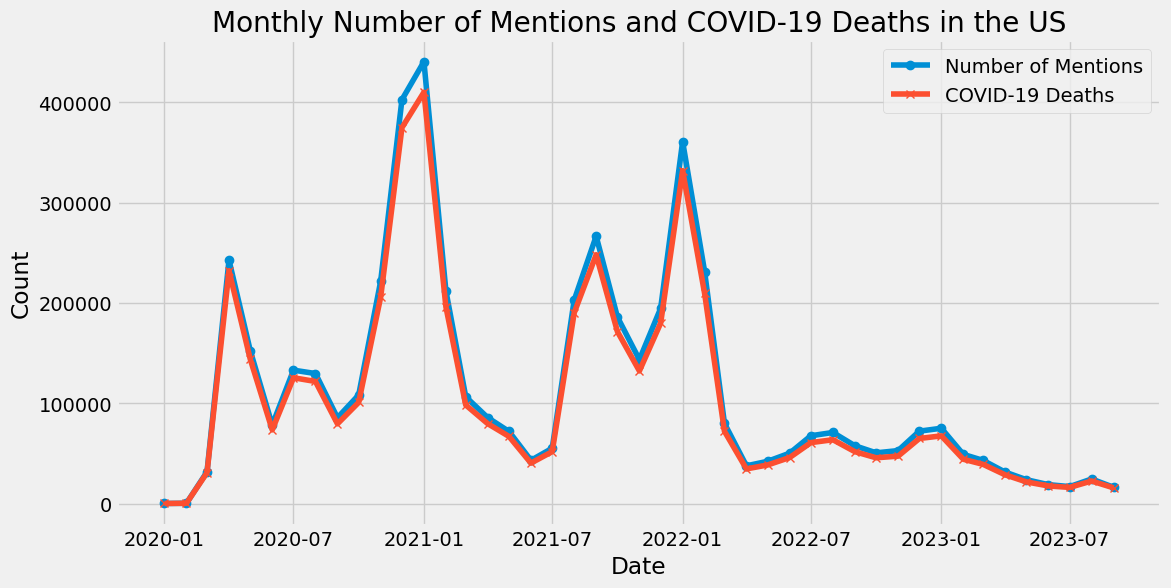

In [9]:
# Plot the line chart for "Number of Mentions" and "COVID-19 Deaths"
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Date'], monthly_data['Number of Mentions'], marker='o', label='Number of Mentions')
plt.plot(monthly_data['Date'], monthly_data['COVID-19 Deaths'], marker='x', label='COVID-19 Deaths')
plt.title('Monthly Number of Mentions and COVID-19 Deaths in the US')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

### The line chart shows significant fluctuations in the number of mentions and COVID-19 deaths over time, with notable peaks around winter months.

# 4. Decompose the Data's Components

### The time-series data will now be decomposed into its three main components: trend, seasonality, and residuals. 
### The decomposition is performed for both "Number of Mentions" and "COVID-19 Deaths".

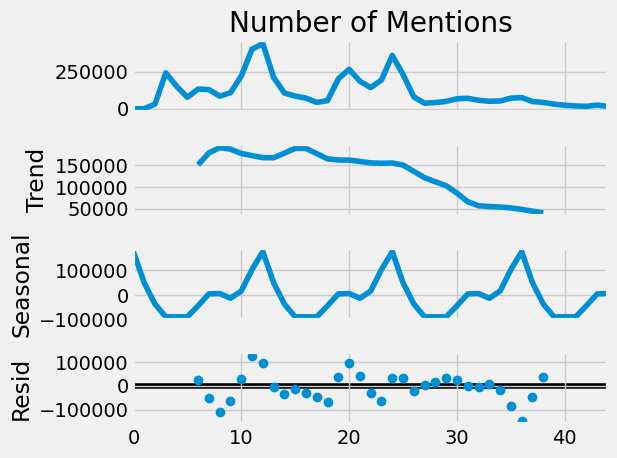

In [10]:
# Decompose the data's components for Number of Mentions
result_mentions = seasonal_decompose(monthly_data['Number of Mentions'], model='additive', period=12)
result_mentions.plot()
plt.show()

### The decomposition of the "Number of Mentions" shows a clear trend, indicating an increase followed by a decrease over time. The seasonal component shows periodic fluctuations, as expected from the line chart. The residuals appear to be relatively random, indicating that most patterns in the data are captured by the trend and seasonality.

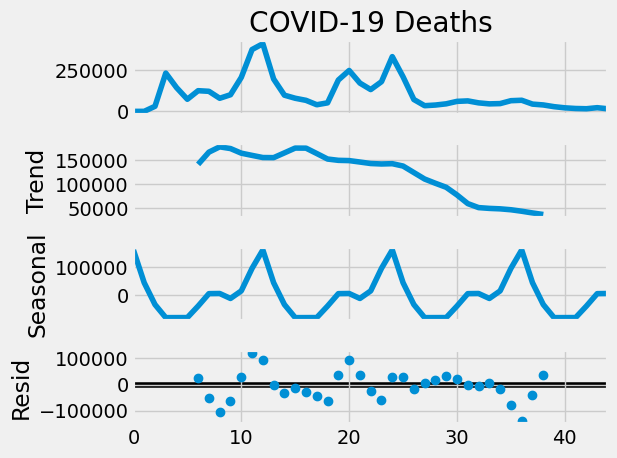

In [11]:
# Decompose the data's components for COVID-19 Deaths
result_deaths = seasonal_decompose(monthly_data['COVID-19 Deaths'], model='additive', period=12)
result_deaths.plot()
plt.show()

### The decomposition of the "COVID-19 Deaths" series shows a similar pattern to the "Number of Mentions". There is a clear trend and seasonal component, with residuals appearing to be more or less random.

# 5. Conduct a Dickey-Fuller Test to Check for Stationarity

### Perform the Dickey-Fuller test to check if the time series data for "Number of Mentions" and "COVID-19 Deaths" are stationary.

In [12]:
# Function to perform the Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        return False
    else:
        return True

In [13]:
# Check stationarity for both series
stationary_mentions = check_stationarity(monthly_data['Number of Mentions'])
stationary_deaths = check_stationarity(monthly_data['COVID-19 Deaths'])

ADF Statistic: -2.409709333513477
p-value: 0.13901475276690195
ADF Statistic: -2.410708973811163
p-value: 0.13873666462858447


### The results for both "Number of Mentions" and "COVID-19 Deaths" show p-values greater than 0.05 (0.1390 and 0.1387, respectively). This indicates that we fail to reject the null hypothesis of non-stationarity. 
### The data is not stationary and requires differencing to stabilize the mean.

# 6. Differencing the Data if Not Stationary

### Apply differencing to the time series data for "Number of Mentions" and "COVID-19 Deaths" to make them stationary.

In [14]:
# Differencing the data for Number of Mentions if not stationary
if not stationary_mentions:
    monthly_data['Number of Mentions Diff'] = monthly_data['Number of Mentions'].diff().dropna()
    stationary_mentions = check_stationarity(monthly_data['Number of Mentions Diff'].dropna())

ADF Statistic: -3.68221527010616
p-value: 0.004370381677858634


In [15]:
# Differencing the data for COVID-19 Deaths if not stationary
if not stationary_deaths:
    monthly_data['COVID-19 Deaths Diff'] = monthly_data['COVID-19 Deaths'].diff().dropna()
    stationary_deaths = check_stationarity(monthly_data['COVID-19 Deaths Diff'].dropna())

ADF Statistic: -3.688445985815622
p-value: 0.004278638266179719


### After applying differencing, the Dickey-Fuller test results show significant improvements:
    For "Number of Mentions", the ADF Statistic is -3.6822 with a p-value of 0.0044.
    For "COVID-19 Deaths", the ADF Statistic is -3.6884 with a p-value of 0.0043.
### Both p-values are now less than 0.05, allowing us to reject the null hypothesis of non-stationarity. 
### The differenced data is now stationary and suitable for time-series modeling.

# 7. Check the Data’s Autocorrelations

### Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for the differenced series of "Number of Mentions" and "COVID-19 Deaths".
### Identify the appropriate initial parameters (p, d, q) for the ARIMA model by showing how the data points are correlated with their past values.

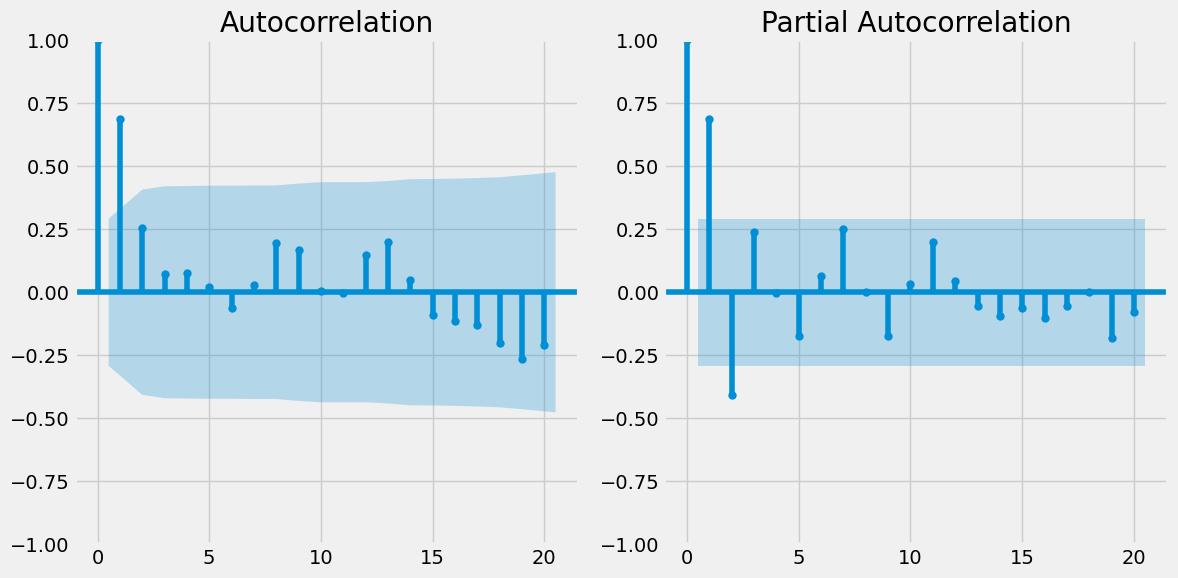

In [16]:
# Plot ACF and PACF for Number of Mentions
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_data['Number of Mentions'].dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation')
plt.subplot(122)
plot_pacf(monthly_data['Number of Mentions'].dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

### The ACF and PACF plots for "Number of Mentions" indicate significant autocorrelations at lag 1, suggesting an ARIMA model with parameters (p, d, q) = (1, 1, 1) might be appropriate.

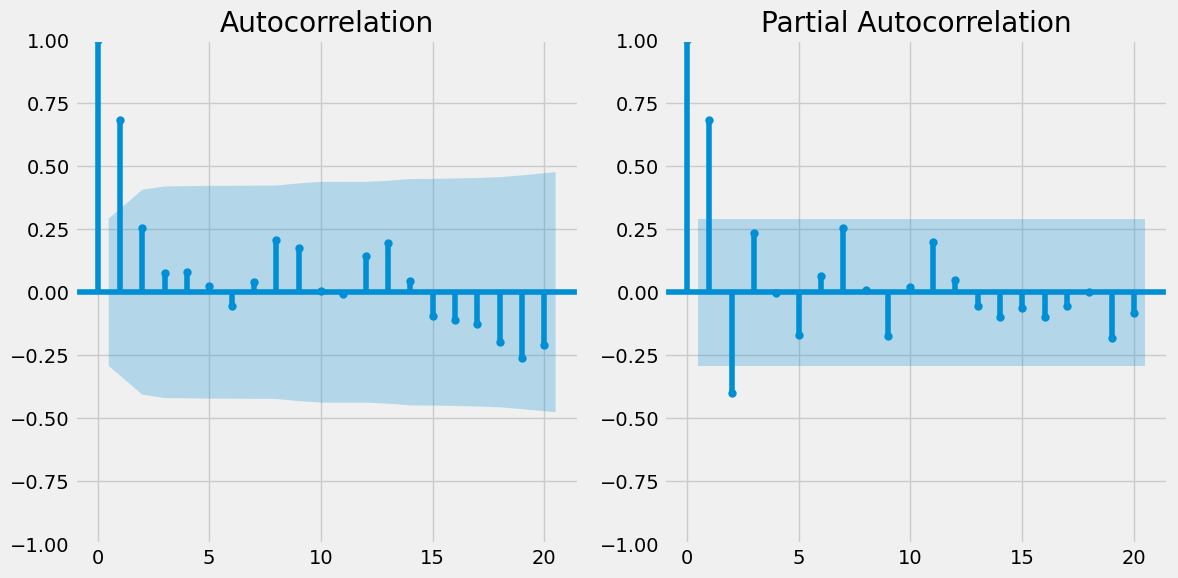

In [17]:
# Plot ACF and PACF for COVID-19 Deaths
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_data['COVID-19 Deaths'].dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation')
plt.subplot(122)
plot_pacf(monthly_data['COVID-19 Deaths'].dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

### The ACF and PACF plots for "COVID-19 Deaths" also show significant autocorrelations at lag 1. This suggests that an ARIMA model with parameters (p, d, q) = (1, 1, 1) could also be suitable for modeling "COVID-19 Deaths".

# 8. Summary and Next Steps

### Summary
### 1. Data Preprocessing: "Year" and "Month" columns were converted to integers and a new "Date" column was created. The data was then aggregated by month to facilitate time series analysis.
### 2. Visualization: Line charts were plotted to visualize the monthly trends in the "Number of Mentions" and "COVID-19 Deaths". This helped identify patterns and significant fluctuations over time.
### 3. Decomposition: The time series data was decomposed into its trend, seasonality, and residual components. This allowed us to understand the underlying patterns in the data.
### 4. Stationarity Check: The Dickey-Fuller test was performed to check for stationarity. The test indicated that the original series were not stationary, so differencing was applied to stabilize the mean.
### 5. Autocorrelation Analysis: ACF and PACF plots were created for the differenced series. These plots indicated significant autocorrelations at lag 1 for both "Number of Mentions" and "COVID-19 Deaths".

### Next Steps
### 1. Model Implementation: Implement the ARIMA model with parameters (1, 1, 1) for both "Number of Mentions" and "COVID-19 Deaths". Evaluate the model's performance using the Mean Squared Error (MSE).
### 2. Forecasting: Use the ARIMA model to forecast future values. This will help predict trends and potential future peaks in the number of mentions and COVID-19 deaths.
### 3. Model Refinement: Experiment with different iterations of the ARIMA model to see if a better fit can be achieved. Consider using seasonal ARIMA (SARIMA) as there is a pattern of seasonality in the data.

# End